In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install yfinance
!pip install tensorflow
!pip install matplotlib
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## LSTM for stock prediction

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.8.2


### Setting model parameter

In [4]:
import pandas as pd
from datetime import datetime
EPOCHS = 200
BATCH_SIZE = 32
TIME_STEPS = 10
MEAN = 10
STOCK_TICKER = 'IBM' # Ticker of company
STOCK_START_DATE = pd.to_datetime('1992-01-01')     # Train data from start date to validation date
STOCK_END_DATE = pd.to_datetime('2022-01-04')
STOCK_TRAIN_PER = 0.7
STOCK_TEST_PER = 0.2
FEATURE = ["Open", 'High', 'Low', 'Close', 'Volume']
CHECKPOINT_FOLDER = "/content/drive/My Drive/Colab Notebooks/checkpoint/lstm"

### Read data and split data to train and test

In [5]:
from matplotlib.pyplot import axis
import yfinance as yf
print("Train Data From: " + STOCK_START_DATE.strftime("%Y-%m-%d"), end=" ")
print('To: ' + STOCK_END_DATE.strftime("%Y-%m-%d"))
df = yf.download([STOCK_TICKER], start=STOCK_START_DATE, end=STOCK_END_DATE)
df = df.drop("Adj Close", axis=1)
df.head()

Train Data From: 1992-01-01 To: 2022-01-04
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
1992-01-02,21.271511,21.659895,21.241634,21.570269,7451286
1992-01-03,21.570269,21.779398,21.510515,21.600143,6069310
1992-01-06,21.749521,22.257408,21.719646,22.048279,9198524
1992-01-07,21.988527,22.645794,21.958652,22.615917,8255032
1992-01-08,22.466539,22.705545,22.048279,22.078156,10526526


### Moving Average closing price

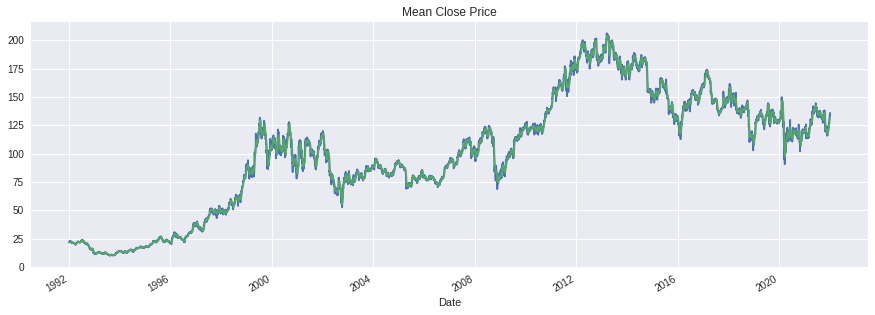

In [6]:
import matplotlib.pyplot as plt
# Apply moving average with a window of MEAN days to all columns
df_mean = df[FEATURE].rolling(MEAN).mean() 
# Drop all rows with NaN values
df_mean.dropna(how='any', axis=0, inplace=True)
plt.figure(figsize=(15, 5))
df['Close'].plot(title="Close Price")
df_mean['Close'].plot(title="Mean Close Price")

### Plot dayly closing price

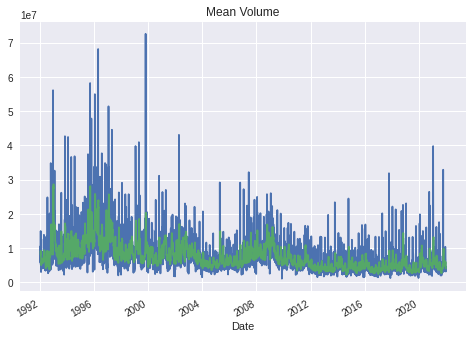

In [7]:
df['Volume'].plot(title="Volume")
df_mean['Volume'].plot(title="Mean Volume")

### Calculate percentage change

In [8]:
'''Calculate percentage change'''

df_mean['Open'] = df_mean['Open'].pct_change() # Create arithmetic returns column
df_mean['High'] = df_mean['High'].pct_change() # Create arithmetic returns column
df_mean['Low'] = df_mean['Low'].pct_change() # Create arithmetic returns column
df_mean['Close'] = df_mean['Close'].pct_change() # Create arithmetic returns column
df_mean['Volume'] = df_mean['Volume'].pct_change()

df_mean.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

### Data distribution

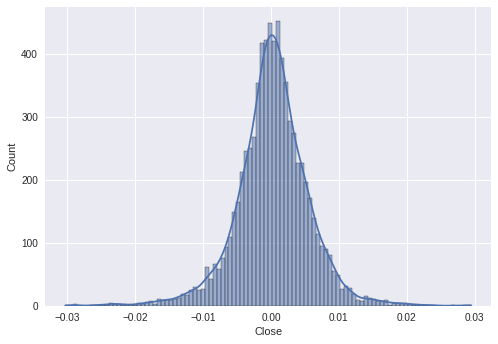

In [9]:
import seaborn as sns
sns.histplot(df_mean['Close'], kde=True)

### Split data

In [10]:
times = sorted(df_mean.index.values)
train_index = times[int(STOCK_TRAIN_PER*len(times))]
test_index = times[-int(STOCK_TEST_PER*len(times))]
df_train = df_mean[df_mean.index < train_index].copy()
df_test = df_mean[df_mean.index >= test_index].copy()
df_val = df_mean[(df_mean.index < test_index) & (df_mean.index >= train_index)].copy()

print('Training data shape: {}'.format(df_train.shape))
print('Validation data shape: {}'.format(df_val.shape))
print('Testing data shape: {}'.format(df_test.shape))

Training data shape: (5284, 5)
Validation data shape: (756, 5)
Testing data shape: (1509, 5)


### Plot daly change

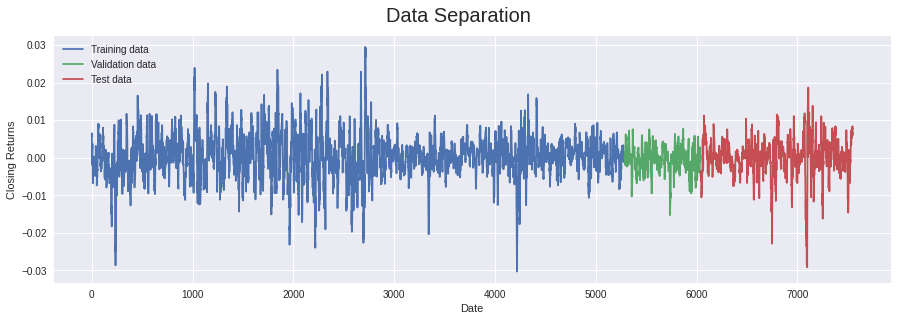

In [11]:
import numpy as np
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(df_train.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(df_train.shape[0], 
                   df_train.shape[0]+df_val.shape[0]), df_val['Close'], label='Validation data')
ax1.plot(np.arange(df_train.shape[0] + df_val.shape[0], 
                   df_train.shape[0]+df_val.shape[0] +df_test.shape[0]), df_test['Close'], label='Test data')

ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Returns')


plt.legend(loc='best')

### Normalization

In [12]:
from sklearn.preprocessing import MinMaxScaler
'''Normalize price columns'''
scaler = MinMaxScaler()
scaler.fit(df_train[FEATURE])
train_scaled = scaler.transform(df_train[FEATURE])
val_scaled = scaler.transform(df_val[FEATURE])
test_scaled = scaler.transform(df_test[FEATURE])
print(type(train_scaled))

<class 'numpy.ndarray'>


### Create label

In [13]:
def create_data_label(data_train, step=60):
    """ Serialize data by slide window and generate labels after each time step
        default timesteps is 60 day
        param:
          data_train - numpy.ndarray with shape (length, 5)
    """
    upper = data_train.shape[0]
    if step >= upper:
        print("step is greater than data")
        return
    x_train = []
    y_train = []
    for i in range(step, upper):
        x_train.append(data_train[i - step:i])
        y_train.append(data_train[i][3])    # (Close price) is label
    x_train, y_train = np.array(x_train), np.array(y_train)
    return x_train, y_train
# Serialize data and generate labels for train data
x_train, y_train = create_data_label(train_scaled, TIME_STEPS)
x_validation, y_validation = create_data_label(val_scaled, TIME_STEPS)
x_test, y_test = create_data_label(test_scaled, TIME_STEPS)
print('Shape Of X_Train Data :')
print(x_train.shape)
print('Shape of X_Validation Data :')
print(x_validation.shape)
print('Shape of X_Test Data :')
print(x_test.shape)

Shape Of X_Train Data :
(5274, 10, 5)
Shape of X_Validation Data :
(746, 10, 5)
Shape of X_Test Data :
(1499, 10, 5)


### LSTM Model

In [14]:
model = Sequential()
in_seq = InputLayer(input_shape = (x_train.shape[1], 5))
model.add(in_seq)
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=96))
model.add(Dropout(0.25))
model.add(Dense(units=1))
model.summary()
model.compile(loss="mse", optimizer="adam", metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError("rmse")])    


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 96)            39168     
                                                                 
 dropout (Dropout)           (None, 10, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 10, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 10, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

### Train model

In [15]:
#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
# callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              # callbacks=[callback],
              epochs=EPOCHS,
              #shuffle=True,
              validation_data=(x_validation, y_validation))    

model.save(CHECKPOINT_FOLDER)

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(x_train)
val_pred = model.predict(x_validation)
test_pred = model.predict(x_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(x_train, y_train, verbose=0)
val_eval = model.evaluate(x_validation, y_validation, verbose=0)
test_eval = model.evaluate(x_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss(MSE): {:.4f}, MAE: {:.4f}, RMSE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss(MSE): {:.4f}, MAE: {:.4f}, RMSE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss(MSE): {:.4f}, MAE: {:.4f}, RMSE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

Epoch 1/200
165/165 [==============================] - 29s 104ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0915 - rmse: 0.1281 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0446 - val_rmse: 0.0575
Epoch 2/200
165/165 [==============================] - 8s 47ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0733 - rmse: 0.0966 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0425 - val_rmse: 0.0545
Epoch 3/200
165/165 [==============================] - 7s 41ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0681 - rmse: 0.0897 - val_loss: 0.0023 - val_mse: 0.0023 - val_mae: 0.0380 - val_rmse: 0.0479
Epoch 4/200
165/165 [==============================] - 7s 41ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0577 - rmse: 0.0757 - val_loss: 0.0022 - val_mse: 0.0022 - val_mae: 0.0378 - val_rmse: 0.0467
Epoch 5/200
165/165 [==============================] - 7s 41ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0539 - rmse: 0.0708 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0281 - val_rmse: 0.037

 
Evaluation metrics
Training Data - Loss(MSE): 0.0012, MAE: 0.0012, RMSE: 0.0252
Validation Data - Loss(MSE): 0.0006, MAE: 0.0006, RMSE: 0.0191
Test Data - Loss(MSE): 0.0013, MAE: 0.0013, RMSE: 0.0239


### Visualize loss by epochs

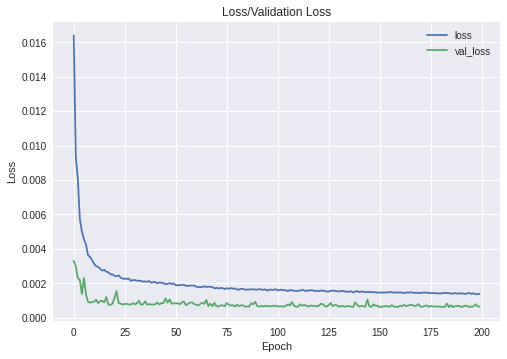

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

    
def visualize_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss/Validation Loss')
    plt.legend(loc='upper right')
    plt.pause(0.001)
    plt.show()
    
def visualize_predict(real_data, predict_data, model_name="LSTM"):
    plt.figure(figsize=(16,6))
    plt.plot(real_data, label='True Value')
    plt.plot(predict_data, label='Predict Value')
    plt.title('Prediction by' + model_name)
    plt.xlabel('Time Scale')
    plt.ylabel('Scaled USD')
    plt.legend()
    plt.show()
visualize_loss(history)

### Display result

Text(0, 0.5, 'IBM Closing Return')

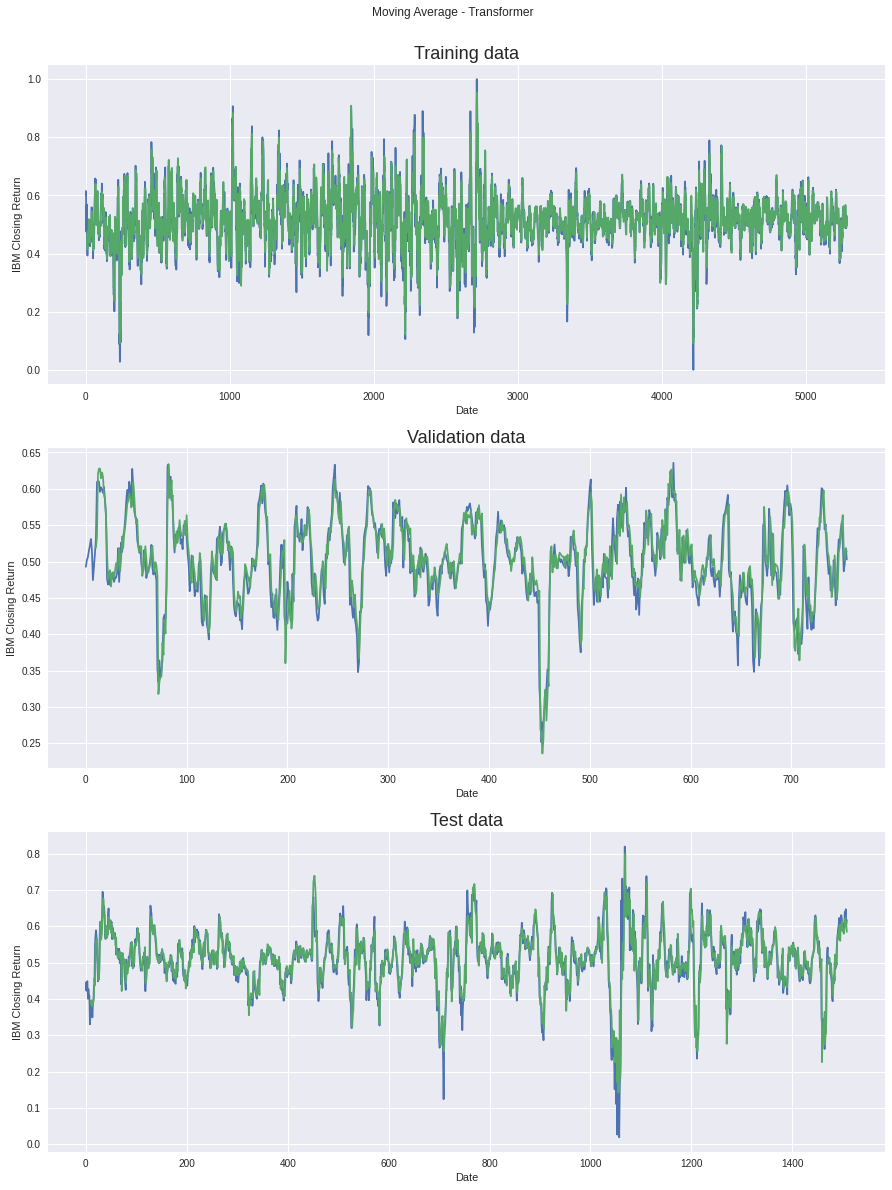

In [17]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)
val_pred = model.predict(x_validation)
fig = plt.figure(figsize=(15, 20))
st = fig.suptitle("Moving Average - Transformer")
st.set_y(0.92)

# Plot training data
ax11 = fig.add_subplot(311)
ax11.plot(train_scaled[:, 3], label="IBM Closing Returns")
ax11.plot(np.arange(TIME_STEPS, train_pred.shape[0]+ TIME_STEPS), train_pred, label="Predicted IBM closing return")
ax11.set_title("Training data", fontsize=18)
ax11.set_xlabel("Date")
ax11.set_ylabel("IBM Closing Return")

# Plot validation data
ax11 = fig.add_subplot(312)
ax11.plot(val_scaled[:, 3], label="IBM Closing Returns")
ax11.plot(np.arange(TIME_STEPS, val_pred.shape[0]+ TIME_STEPS), val_pred, label="Predicted IBM closing return")
ax11.set_title("Validation data", fontsize=18)
ax11.set_xlabel("Date")
ax11.set_ylabel("IBM Closing Return")

# Plot test data
ax11 = fig.add_subplot(313)
ax11.plot(test_scaled[:, 3], label="IBM Closing Returns")
ax11.plot(np.arange(TIME_STEPS, test_pred.shape[0]+ TIME_STEPS), test_pred, label="Predicted IBM closing return")
ax11.set_title("Test data", fontsize=18)
ax11.set_xlabel("Date")
ax11.set_ylabel("IBM Closing Return")